# Autoencoder-based Anomaly Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from scipy.io.arff import loadarff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import itertools
import time
import random

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score, precision_score, recall_score
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import imblearn
from imblearn.over_sampling import SMOTE
from keras.layers import BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Convolution2D as Conv2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Retrieving data

In [ ]:
#Upload the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [ ]:
dataframe.shape

(4998, 141)

##Data Augementation

In [ ]:
data_1 = dataframe[dataframe[140] == 1]
data_2 = dataframe[dataframe[140] == 0]
data_2

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
292,-0.032245,-0.545050,-0.822340,-1.605085,-1.805775,-2.008067,-2.233975,-2.191458,-2.058071,-1.880849,...,-1.621376,-2.329090,-3.049894,-3.620413,-4.210482,-4.043785,-3.051813,-2.806866,-0.879666,0.0
293,-0.003377,-0.279265,-0.230519,-0.635978,-0.894795,-1.023105,-1.243738,-1.458372,-1.677896,-1.784530,...,-2.640508,-3.218384,-3.651630,-3.881198,-3.924672,-3.164390,-2.228373,-1.837544,-0.378489,0.0
294,0.195989,-0.222258,-0.754773,-1.415614,-1.775851,-2.162326,-2.467492,-2.331384,-1.993476,-1.611709,...,-0.935030,-1.654340,-2.434240,-3.472170,-4.280780,-4.629438,-3.794192,-2.851468,-1.743521,0.0
295,0.894867,-0.003822,-0.751052,-1.396543,-1.737838,-2.113020,-2.213210,-2.203347,-2.024191,-1.591458,...,-1.441516,-1.861612,-2.321381,-2.884877,-3.530246,-4.412515,-3.903331,-3.567106,-1.536338,0.0
296,1.250060,0.760800,0.042925,-0.627974,-0.963454,-1.261335,-1.652440,-1.888433,-1.935217,-1.808429,...,-0.979223,-1.353969,-1.952051,-2.640386,-3.000281,-3.812490,-3.973360,-5.221946,-3.661793,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [ ]:
from sklearn.utils import resample
data_1_resample = resample(data_1, n_samples=20000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, 
                           random_state=123, replace=True)
dataframe= pd.concat([data_1_resample, data_2_resample])

## Splitting dataset

In [ ]:
raw_data=dataframe.values
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

## Normalizing dataset

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

##Data Visualization

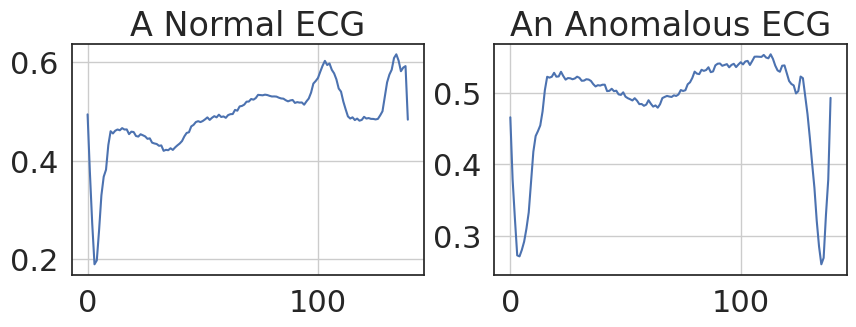

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.grid()
plt.title("A Normal ECG")
plt.plot(np.arange(140), normal_train_data[0])

plt.subplot(1,2,2)
plt.grid()
plt.title("An Anomalous ECG")
plt.plot(np.arange(140), anomalous_train_data[0])

## Ultity Functions

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [ ]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

## Model 1- Sigmoid AF + Adam opt

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
#Training model
checkpoint_path = "path/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
weights = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='mae',
              run_eagerly=True, metrics=['accuracy'])

In [ ]:
history = autoencoder.fit(train_data, train_data, 
          epochs=40, 
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True, 
          callbacks=[weights, 
          tf.keras.callbacks.TensorBoard("/tmp/tb_logs")])

Epoch 1/40
249/250 [============================>.] - ETA: 0s - loss: 0.0216 - accuracy: 0.0623
Epoch 1: saving model to path/cp.ckpt
250/250 [==============================] - 14s 55ms/step - loss: 0.0216 - accuracy: 0.0622 - val_loss: 0.0189 - val_accuracy: 0.0826
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.1067
Epoch 2: saving model to path/cp.ckpt
250/250 [==============================] - 13s 52ms/step - loss: 0.0165 - accuracy: 0.1067 - val_loss: 0.0150 - val_accuracy: 0.1245
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.1385
Epoch 3: saving model to path/cp.ckpt
250/250 [==============================] - 15s 60ms/step - loss: 0.0142 - accuracy: 0.1385 - val_loss: 0.0133 - val_accuracy: 0.1535
Epoch 4/40
249/250 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.1566
Epoch 4: saving model to path/cp.ckpt
250/250 [==============================] - 13s 53ms/step - loss: 

In [ ]:
# Loads the weights
autoencoder.load_weights(checkpoint_path)
#Testing model
autoencoder.evaluate(test_data,  test_data, verbose=2)

250/250 - 3s - loss: 0.0108 - accuracy: 0.1805 - 3s/epoch - 12ms/step


[0.010837114416062832, 0.18050000071525574]

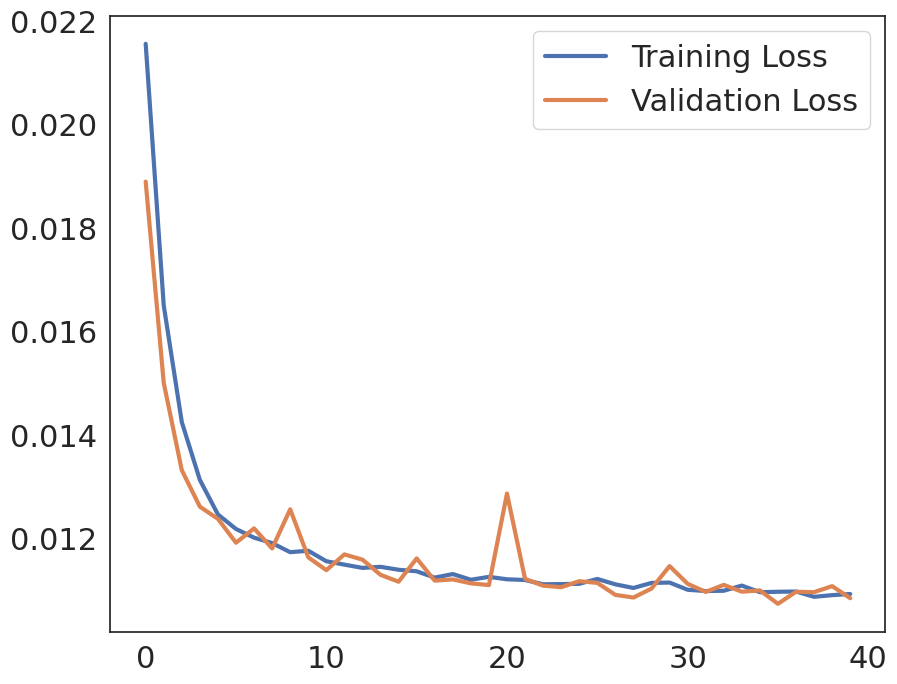

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs/

import IPython

display(IPython.display.HTML('''
<button id='open_tb'>Open TensorBoard</button> 
<button id='hide_tb'>Hide TensorBoard</button> 
<script>document.querySelector('#open_tb').onclick = () => { window.open(document.querySelector('iframe').src, "__blank") }
        document.querySelector('#hide_tb').onclick = () => { document.querySelector('iframe').style.display = "none" }</script>'''))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 892), started 3:25:39 ago. (Use '!kill 892' to kill it.)

<IPython.core.display.Javascript object>

1000/1000 [==============================] - 6s 6ms/step


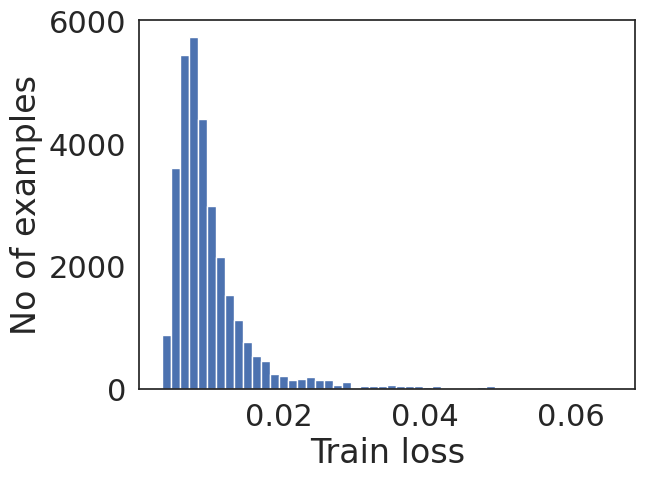

In [ ]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold=np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.017532505


In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

250/250 [==============================] - 1s 6ms/step
Accuracy = 0.50675
Precision = 0.5028078345432132
Recall = 0.9207424128417356


confusion matrix
[[ 383 3630]
 [ 316 3671]]
accuracy: 0.5068, precision: 0.5028, recall: 0.9207,    F1: 0.6504, AUC:0.5081


<Axes: >

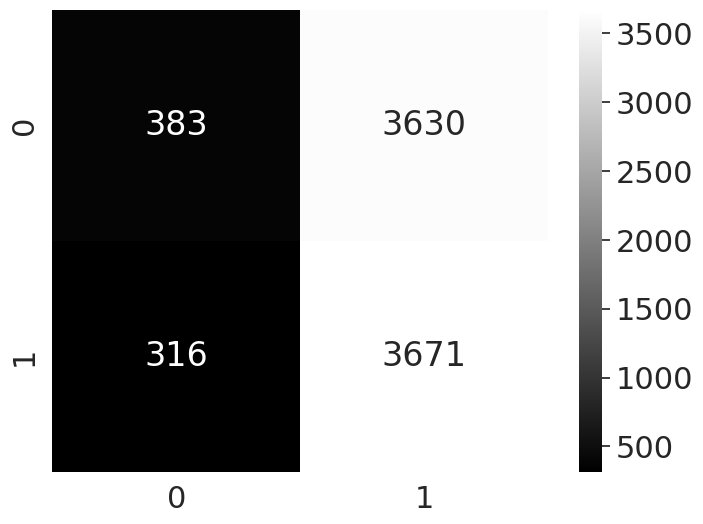

In [ ]:
confusion_matrix = get_clf_eval(test_labels, preds)
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')

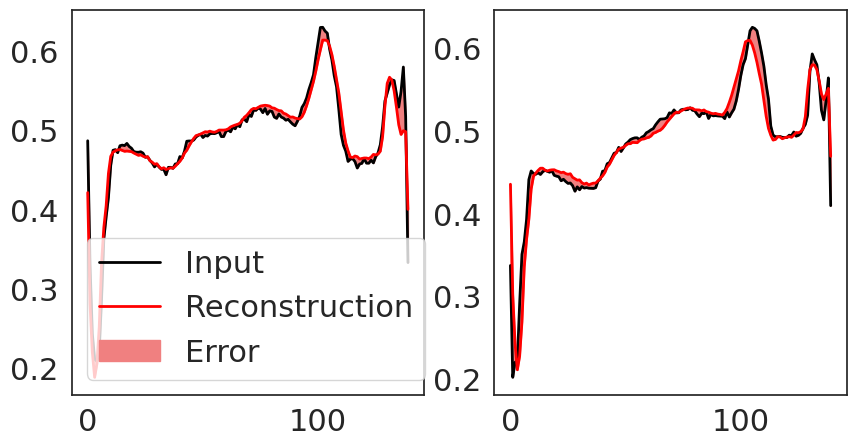

In [ ]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(normal_test_data[0], 'black',linewidth=2)
plt.plot(decoded_imgs[0], 'red',linewidth=2)
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])


plt.subplot(1,2,2)
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(normal_test_data[1], 'black',linewidth=2)
plt.plot(decoded_imgs[1], 'red',linewidth=2)
plt.fill_between(np.arange(140), decoded_imgs[1], normal_test_data[1], color='lightcoral')
#plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

501/501 [==============================] - 3s 7ms/step


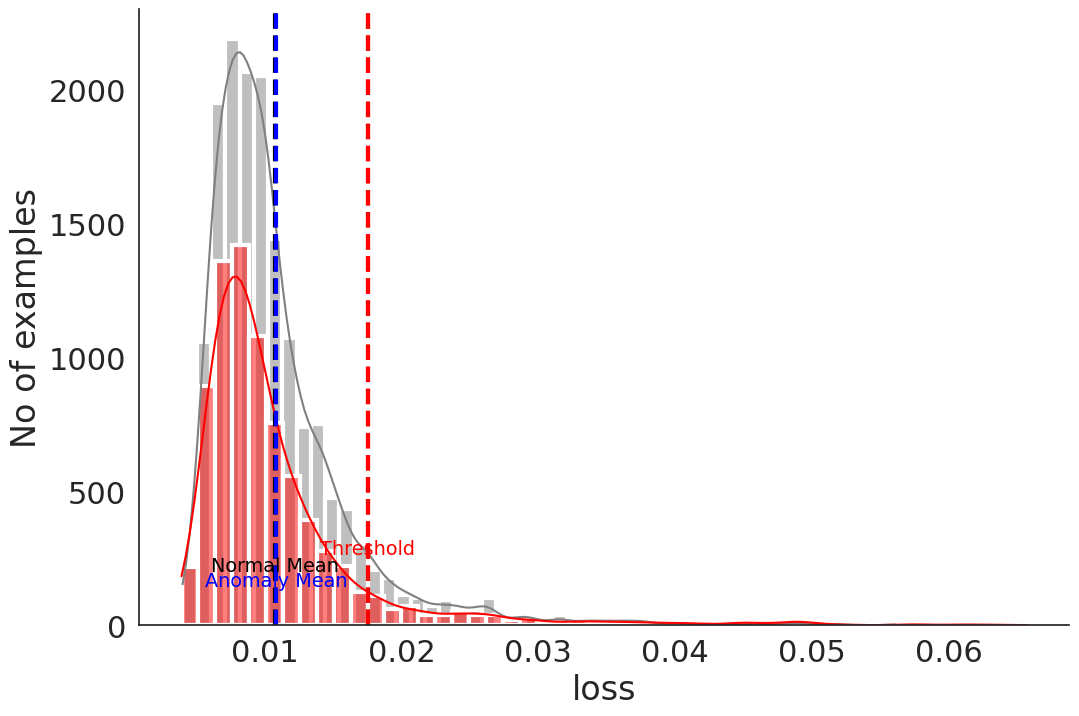

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)

plt.axvline(x=np.mean(train_loss), color='black', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='xx-small', color='black', weight='light')

plt.axvline(x=threshold, color='red', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', va='bottom', 
         size='xx-small', color='red', weight='light')
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)

plt.axvline(x=np.mean(test_loss), color='blue', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', va='top', 
        size='xx-small', color='blue', weight='light')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

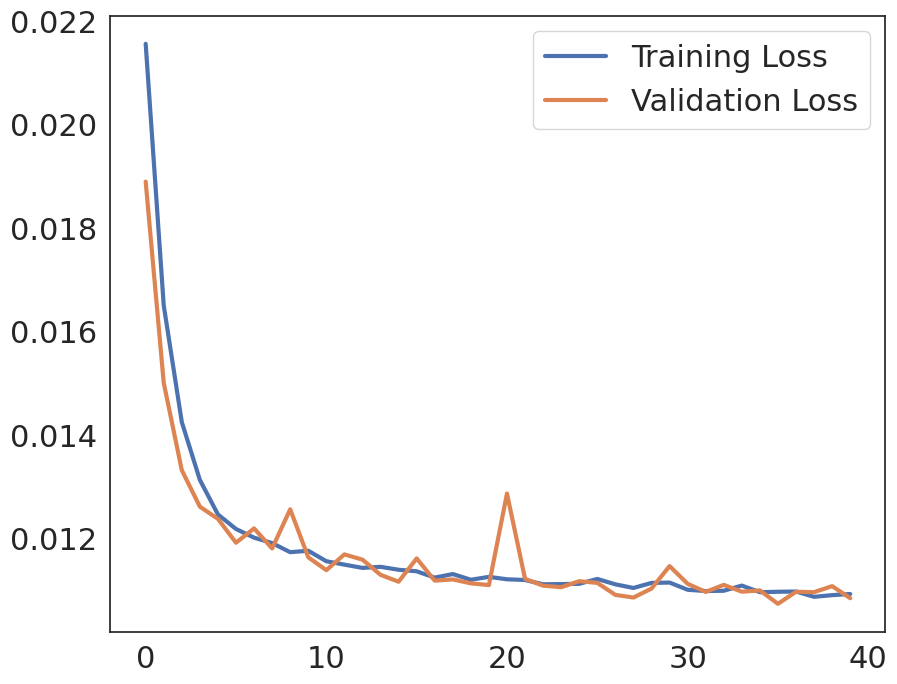

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

## Model 2- Sigmoid AF + RMSProp opt

In [ ]:
#Training model
checkpoint_path = "path/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
weights = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
autoencoder.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss='mae',
              run_eagerly=True, metrics=['accuracy'])

In [ ]:
history = autoencoder.fit(train_data, train_data, 
          epochs=40, 
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True, 
          callbacks=[weights, 
          tf.keras.callbacks.TensorBoard("/tmp/tb_logs")])

Epoch 1/40
249/250 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.0919
Epoch 1: saving model to path/cp.ckpt
250/250 [==============================] - 25s 99ms/step - loss: 0.0211 - accuracy: 0.0917 - val_loss: 0.0236 - val_accuracy: 0.0885
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.0948
Epoch 2: saving model to path/cp.ckpt
250/250 [==============================] - 18s 72ms/step - loss: 0.0187 - accuracy: 0.0948 - val_loss: 0.0164 - val_accuracy: 0.0922
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.1008
Epoch 3: saving model to path/cp.ckpt
250/250 [==============================] - 10s 41ms/step - loss: 0.0177 - accuracy: 0.1008 - val_loss: 0.0160 - val_accuracy: 0.0988
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.1083
Epoch 4: saving model to path/cp.ckpt
250/250 [==============================] - 11s 45ms/step - loss: 

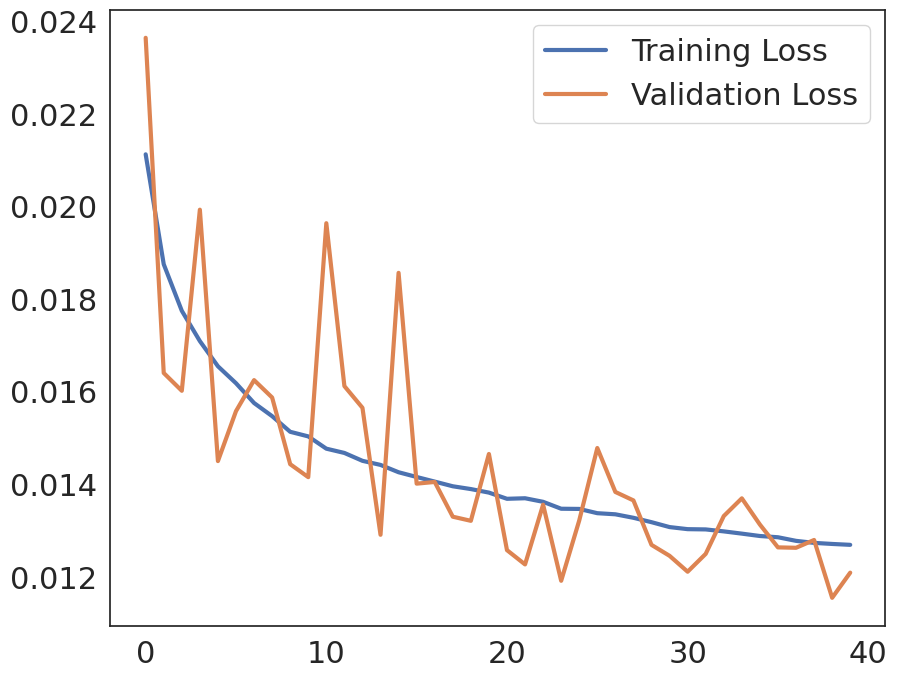

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs/

import IPython

display(IPython.display.HTML('''
<button id='open_tb'>Open TensorBoard</button> 
<button id='hide_tb'>Hide TensorBoard</button> 
<script>document.querySelector('#open_tb').onclick = () => { window.open(document.querySelector('iframe').src, "__blank") }
        document.querySelector('#hide_tb').onclick = () => { document.querySelector('iframe').style.display = "none" }</script>'''))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 892), started 3:34:53 ago. (Use '!kill 892' to kill it.)

<IPython.core.display.Javascript object>

1000/1000 [==============================] - 7s 7ms/step


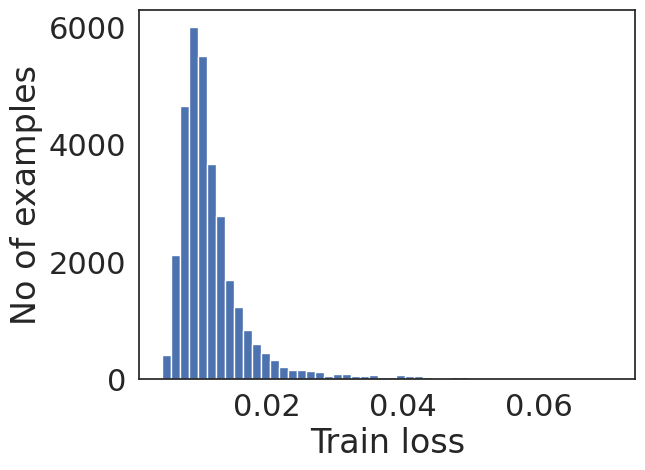

In [ ]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold=np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.018505845


In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

250/250 [==============================] - 2s 7ms/step
Accuracy = 0.507875
Precision = 0.5034209085933223
Recall = 0.9227489340356158


<Axes: >

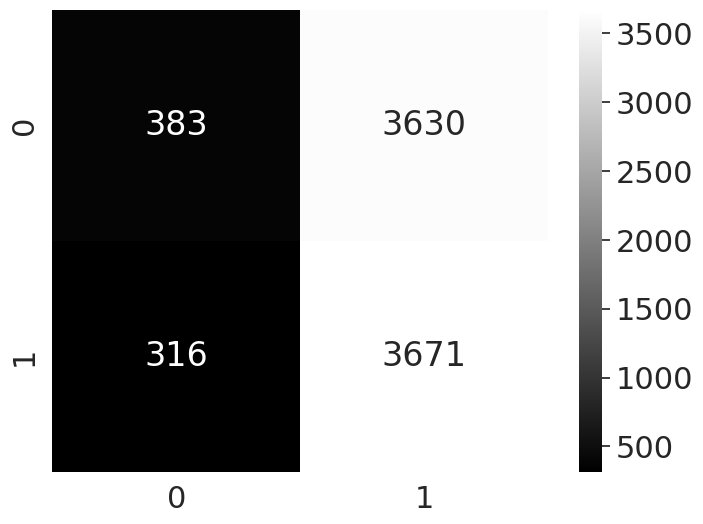

In [ ]:
#confusion_matrix = get_clf_eval(test_labels, preds)
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')

501/501 [==============================] - 4s 7ms/step


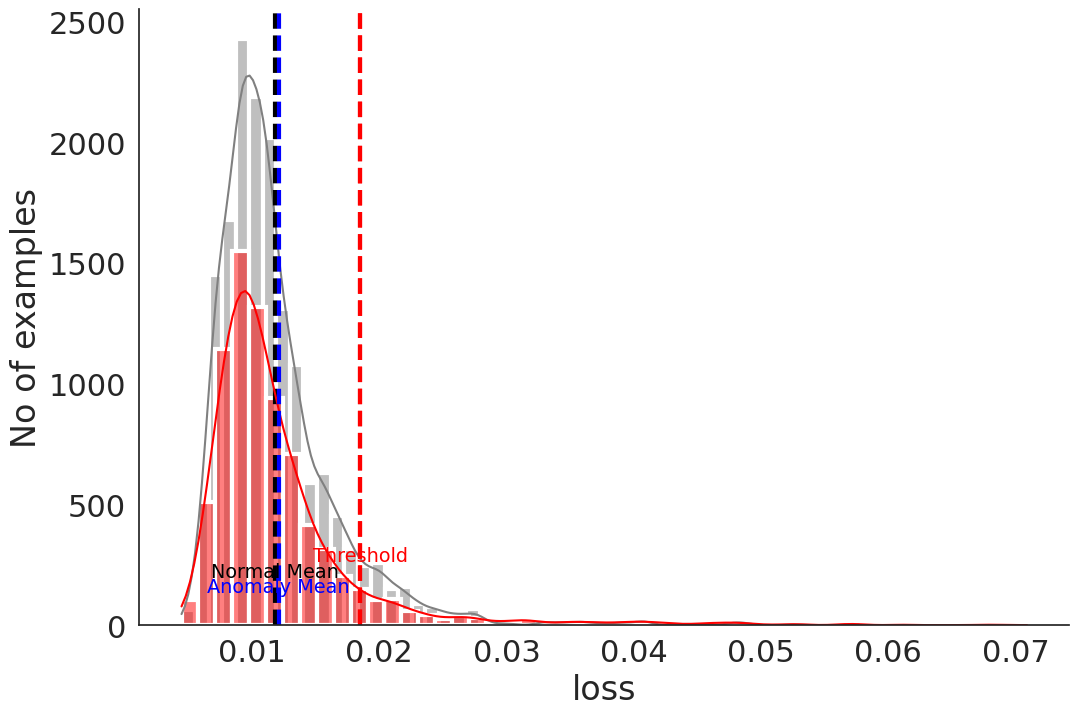

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)

plt.axvline(x=np.mean(train_loss), color='black', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='xx-small', color='black', weight='light')

plt.axvline(x=threshold, color='red', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', va='bottom', 
         size='xx-small', color='red', weight='light')
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)

plt.axvline(x=np.mean(test_loss), color='blue', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', va='top', 
        size='xx-small', color='blue', weight='light')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

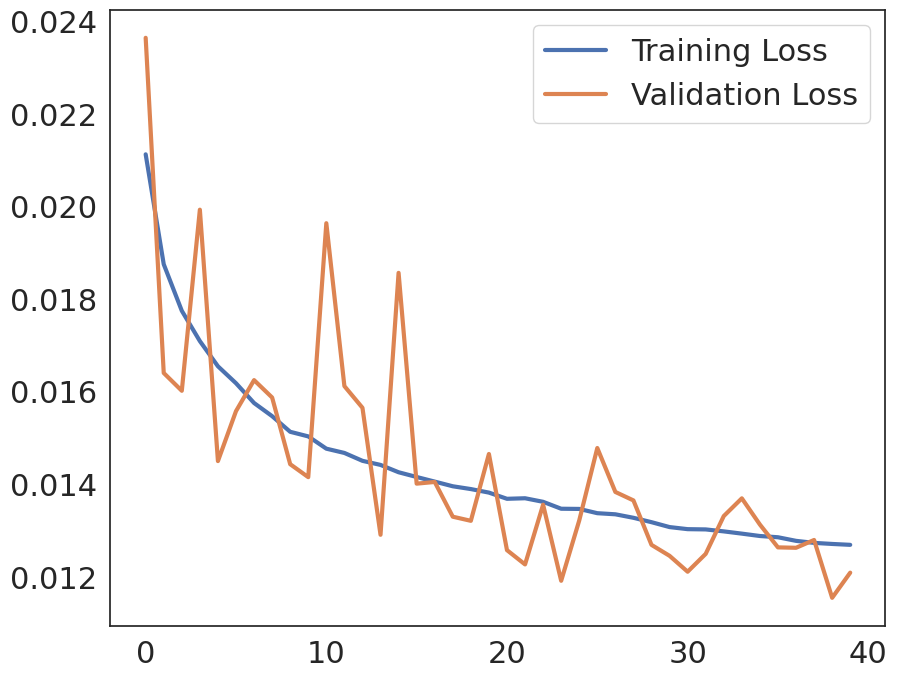

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

##Model 3-Sigmoid AF+ SGD opt 

In [ ]:
#Training model
checkpoint_path = "path/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
weights = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
autoencoder.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='mae',
              run_eagerly=True)

In [ ]:
history = autoencoder.fit(train_data, train_data, 
          epochs=40, 
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True, 
          callbacks=[weights, 
          tf.keras.callbacks.TensorBoard("/tmp/tb_logs")])

Epoch 1/40
249/250 [============================>.] - ETA: 0s - loss: 0.0117
Epoch 1: saving model to path/cp.ckpt
250/250 [==============================] - 10s 39ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 2/40
249/250 [============================>.] - ETA: 0s - loss: 0.0112
Epoch 2: saving model to path/cp.ckpt
250/250 [==============================] - 8s 32ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.0111
Epoch 3: saving model to path/cp.ckpt
250/250 [==============================] - 9s 37ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 4/40
250/250 [==============================] - ETA: 0s - loss: 0.0110
Epoch 4: saving model to path/cp.ckpt
250/250 [==============================] - 9s 36ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 5/40
250/250 [==============================] - ETA: 0s - loss: 0.0110
Epoch 5: saving model to path/cp.ckpt
250/250 [==============================] - 8s 33ms/step - loss: 

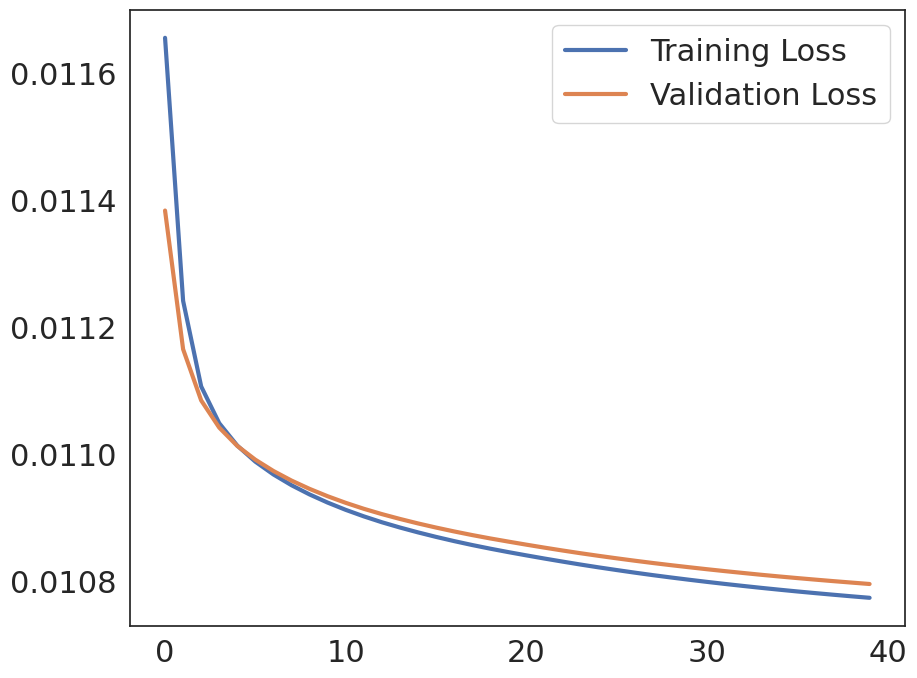

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tb_logs/

import IPython

display(IPython.display.HTML('''
<button id='open_tb'>Open TensorBoard</button> 
<button id='hide_tb'>Hide TensorBoard</button> 
<script>document.querySelector('#open_tb').onclick = () => { window.open(document.querySelector('iframe').src, "__blank") }
        document.querySelector('#hide_tb').onclick = () => { document.querySelector('iframe').style.display = "none" }</script>'''))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 892), started 3:41:08 ago. (Use '!kill 892' to kill it.)

<IPython.core.display.Javascript object>

1000/1000 [==============================] - 6s 6ms/step


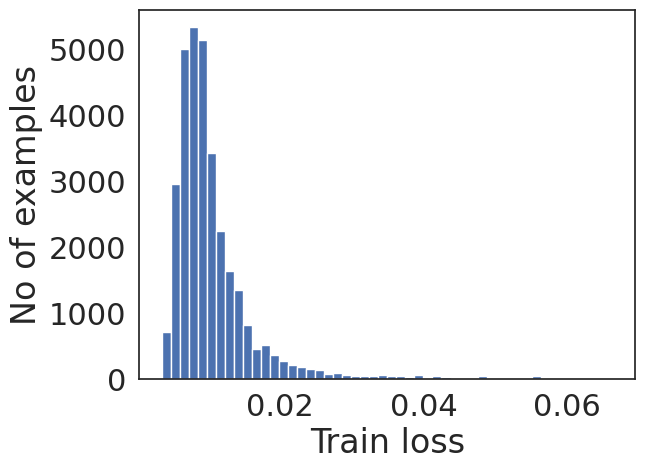

In [ ]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold=np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.01733269


In [ ]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

250/250 [==============================] - 1s 6ms/step
Accuracy = 0.506125
Precision = 0.5024834437086093
Recall = 0.9134687735139202


<Axes: >

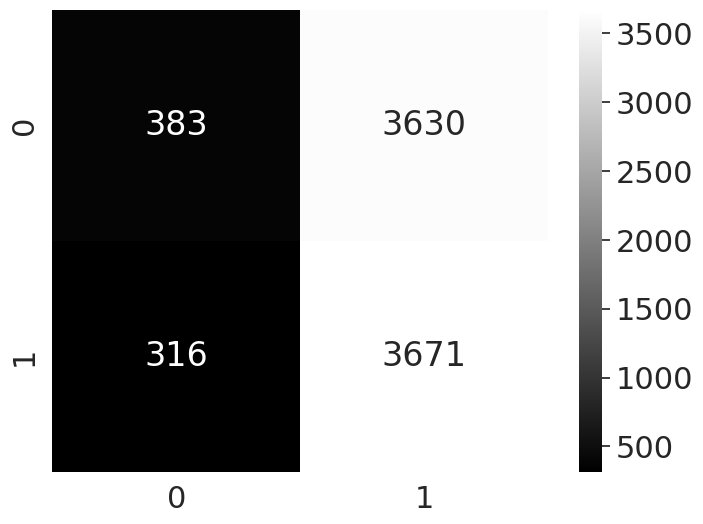

In [ ]:
#confusion_matrix = get_clf_eval(test_labels, preds)
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')

501/501 [==============================] - 3s 6ms/step


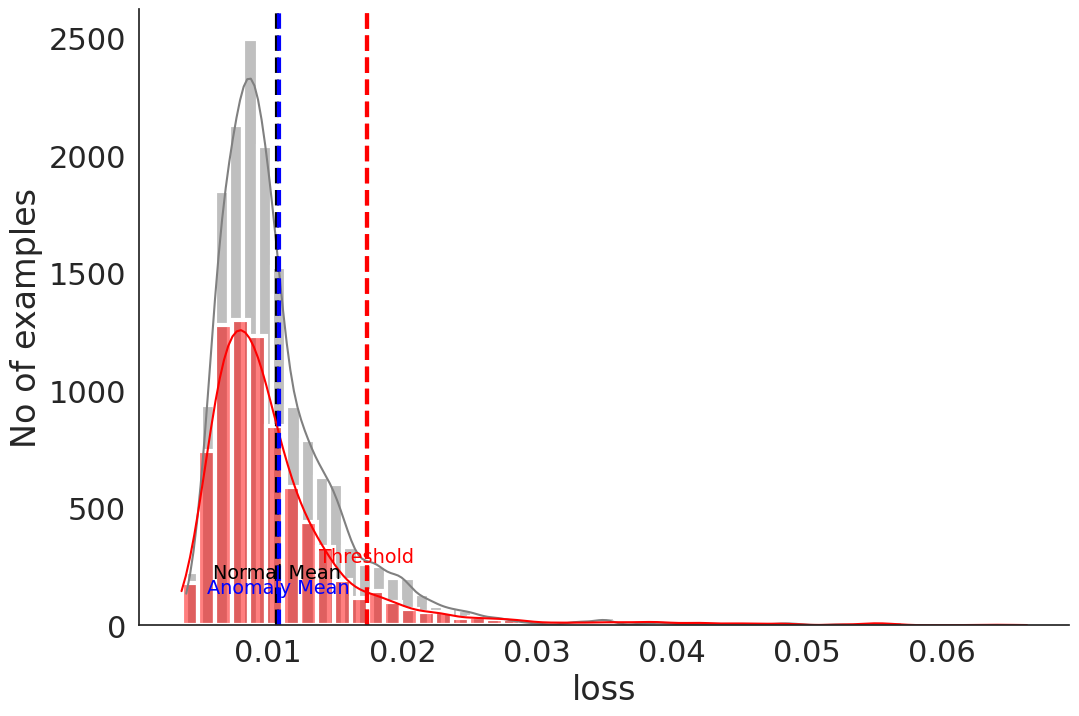

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
plt.figure(figsize=(12,8))
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(train_loss ,bins=50,kde=True,color='grey',linewidth=3)

plt.axvline(x=np.mean(train_loss), color='black', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='xx-small', color='black', weight='light')

plt.axvline(x=threshold, color='red', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', va='bottom', 
         size='xx-small', color='red', weight='light')
sns.histplot(test_loss ,bins=50,kde=True,color='red',linewidth=3)

plt.axvline(x=np.mean(test_loss), color='blue', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Anomaly Mean", horizontalalignment='center', va='top', 
        size='xx-small', color='blue', weight='light')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=3)
plt.xlabel("loss")
plt.ylabel("No of examples")
sns.despine()

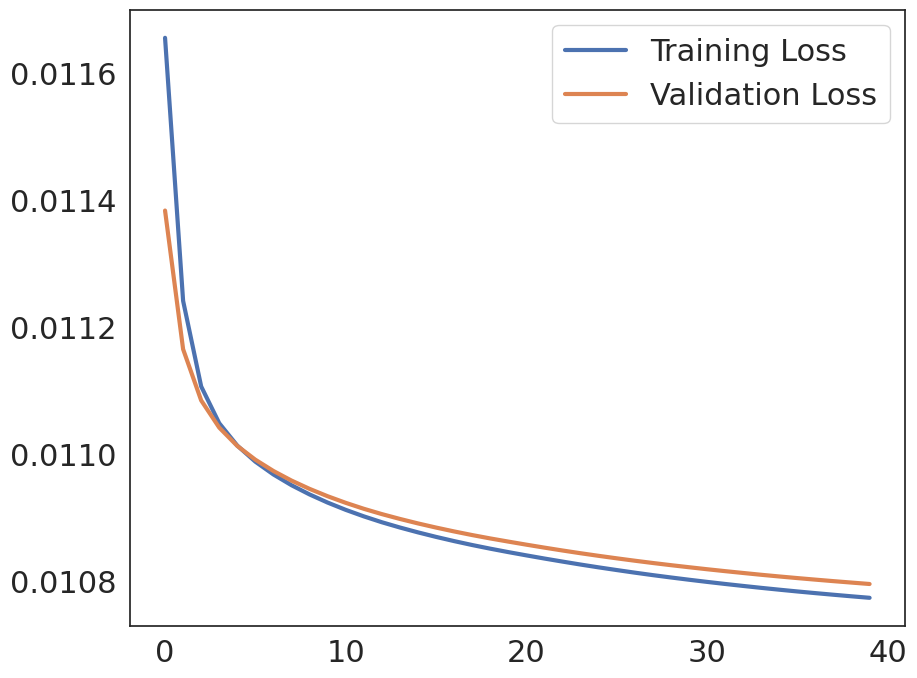

In [ ]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 2)
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss",linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss",linewidth=3.0)
plt.legend()

# Comments on Sigmoid Activation Function on the 1st dataset 

-	Similar to the Tanh activation function variant, the highest accuracy was done by the model variant with the RMSprop optimizer, 0.1 more than the second highest variant, with Adam as its optimizer. 
-	Also, the RMSprop-based variant is the most precise and has the highest True Positive Rate (TPR) relative to the others by a small percentage.
-	On the other hand, the training of the SGD variant is robust relative to RMS variant, as shown above, the SGD variant has a good balance between bias and variance. 
-	Regardless of all that, the highest accuracy is still bad, despite data augmentation being done.  Changing the dataset to a bigger ECG dataset  
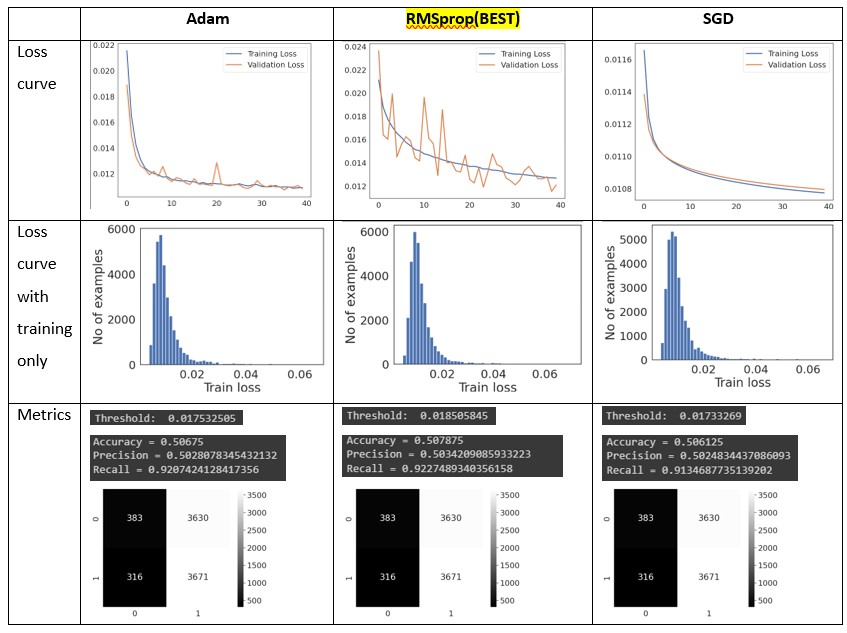
